<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install transformers==4.31.0 datasets==2.14.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


In [53]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import datasets
from transformers import DataCollatorForSeq2Seq

from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
print("Transformers " + transformers.__version__)
print("Datasets " + datasets.__version__)

Transformers 4.46.3
Datasets 3.2.0


In [54]:
#@title Import Dataset

hfDataset = load_dataset("valurank/short-summary")
hfDataset.save_to_disk("/content/hfDataset")
hfDataset['train'] = hfDataset['train'].shuffle(seed=42).select(range(2000))

Saving the dataset (0/1 shards):   0%|          | 0/49673 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/975 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/96 [00:00<?, ? examples/s]

In [55]:
INPUT_NAME = "Excerpt"
OUTPUT_NAME = "Summary"
hfDataset['train'][0]

{'Excerpt': "The House is in historic territory with a proposal to empower Patrick McHenry as an interim speaker. And it's unclear whether enough Republicans would support the plan anyway.",
 'Summary': 'Proposal for Interim Speaker Uncertain'}

In [56]:
# Load model directly
model = TFAutoModelForSeq2SeqLM.from_pretrained("google/t5-efficient-small")
tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-small")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at google/t5-efficient-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [57]:
test_text = hfDataset['test'][INPUT_NAME][16]
test_text

'John Eastman, the controversial lawyer who unsuccessfully pressed Mike Pence to overturn the results of the 2020 presidential race, took center stage at the Jan. 6 panel’s third hearing on Thursday that was focused on the pressure campaign against the former vice president. Eastman emerged in the weeks between the 2020 election and the Jan.…'

In [58]:
def generate_summary(text):
    inputs = tokenizer("summarize: " + text, return_tensors="tf", max_length=1024, truncation=True)
    output_sequences = model.generate(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_length=150)

    return tokenizer.decode(output_sequences[0], skip_special_tokens=True)

print(generate_summary(test_text))

. the 2020 election, the panel said Thursday night at the Jan. 6 panel’s third hearing on Thursday night............................. John Eastman, the lawyer who defended Pence,.....................


In [59]:
def preprocess_data(examples):
    inputs = [ex for ex in examples[INPUT_NAME]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Prepend the input_ids of "summarize:" to the input_ids
    #summarize_ids = tokenizer.encode("summarize: ", add_special_tokens=False)
    model_inputs["input_ids"] = [inp for inp in model_inputs["input_ids"]]

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples[OUTPUT_NAME], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

encoded_dataset = hfDataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/975 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

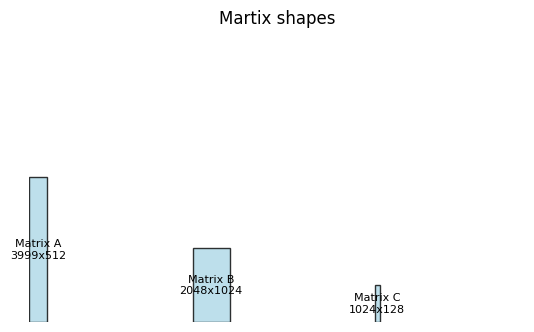

In [ ]:
#@title Plot Matrices
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


Kiek turime apmokymo duomenų (mėginių)?

In [60]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['validation']))

Apmokymo duomenu:  2000
Testavimo duomenu:  975


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [61]:
training_data = encoded_dataset['train']
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

tf_train_dataset = training_data.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=8,
)

tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}>

In [62]:
tf_train_dataset

<_PrefetchDataset element_spec={'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'labels': TensorSpec(shape=(None, 128), dtype=tf.int64, name=None)}>

In [63]:
model.compile(optimizer="adam", loss=model.compute_loss)
model.fit(tf_train_dataset, epochs=3)

Epoch 1/3


AttributeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_tf_utils.py", line 1588, in compute_loss  *
        return super().compute_loss(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss  **
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 275, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/compile_utils.py", line 854, in match_dtype_and_rank
        if (y_t.dtype.is_floating and y_p.dtype.is_floating) or (

    AttributeError: 'NoneType' object has no attribute 'dtype'


Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

In [ ]:
# plot_matrices([np.matrix(encoded_train['input_ids']),
#                np.matrix(encoded_train['labels']),
#                np.matrix(encoded_eval['input_ids']),
#                np.matrix(encoded_eval['labels'])],
#               ["train_input_ids",
#                "train_output_ids",
#                "eval_input_ids",
#                "eval_output_ids"])

Paruošiame klasifikavimo žymių žodynus:

## 2. Modelio inicializavimas ir derinimas

In [ ]:
# from transformers import DataCollatorForSeq2Seq

# data_collator = DataCollatorForSeq2Seq(
#     tokenizer,
#     model=model,
#     label_pad_token_id=tokenizer.pad_token_id,
#     pad_to_multiple_of=8,
#     return_tensors="np"
# )

# tf_train_dataset = model.prepare_tf_dataset(
#     encoded_train,
#     collate_fn=data_collator,
#     shuffle=True,
#     batch_size=16,
# )

# tf_eval_dataset = model.prepare_tf_dataset(
#     encoded_eval,
#     collate_fn=data_collator
# )

AttributeError: 'T5ForConditionalGeneration' object has no attribute 'prepare_tf_dataset'

Ką tik gautas įspėjimas apie kai kuriuos išmestus svorius yra normalus - šiuo atveju mes pašalinome modelio bloką, atsakingą už maskuotą kalbos modeliavimą - tai yra įprasta BERT modelio užduotis, o mes norime atlikti sentimentų analizę (teksto klasifikavimą), dėl ko mums ir reikia papildomas modelio derinimas.

Norime įkelsti mūsų duomenis kaip Tensorflow duomenų rinkinius - tai bus padaryta automatiškai ir atitiks modelio architektūrą:

In [ ]:
!pip install evaluate -q

In [ ]:
# import numpy as np
# import evaluate

# metric = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

Visi `transformers` modeliai pagal nutylėjimą gali patys pasirinkti protingą nuostolių funkciją, todėl mums nereikis dėti `loss` parametro į `compile()`. Tuo metu `transformers` rekomenduoja sukonstruoti `AdamW` tipo optimizatorių patiems:

In [ ]:
# import torch
# torch.cuda.empty_cache()

# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     eval_strategy="epoch",
#     report_to="none",
#     num_train_epochs=1,
#     per_device_train_batch_size=4,
#     fp16=True,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=encoded_train,
#     eval_dataset=encoded_eval,
#     compute_metrics=compute_metrics
# )

# trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 300) + inhomogeneous part.

Laikas fittinti modelį:

In [ ]:
num_epochs = 1
batch_size = 4

batches_per_epoch = len(encoded_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = transformers.create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=['accuracy'])

model.fit(
  training_data=encoded_train,
  validation_data=encoded_eval,
  epochs=num_epochs,
)

#model.save_pretrained("/content/drive/My Drive/Colab/t5-text-summarization.h5")

TypeError: compile() got an unexpected keyword argument 'optimizer'

## 3. Modelio panaudojimas

In [ ]:
test_text = hfDataset['test'][0]
inference_text = tokenizer(test_text['input'], return_tensors="tf", max_length=512, padding="max_length", truncation=True)
#print(test_text['output'])

outputs = model.generate(
    input_ids=inference_text["input_ids"],
    attention_mask=inference_text["attention_mask"],
    max_length=128,
    num_beams=4,
    early_stopping=True
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

In [ ]:
outputs[0]